In [30]:
import pandas as pd
import nltk
import re
import keras
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from nltk.tokenize import ToktokTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Dense, Dropout, Embedding, LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import warnings

warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('IMDB Dataset.csv')

In [3]:
len(data)

50000

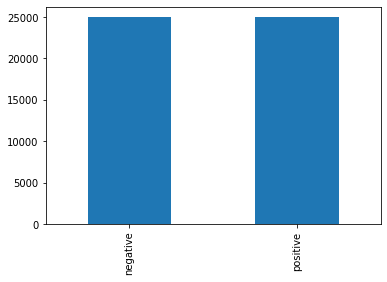

In [4]:
data.sentiment.value_counts().plot.bar()
plt.show()

# Text preprocessing

In [5]:
stop = nltk.corpus.stopwords.words('english')

In [6]:
def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_special_characters(text, remove_digits=True):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub('\[[^]]*\]', '', text)
    text = re.sub(pattern,'',text)
    return text

def remove_stopwords(text, is_lower_case=False):
    tokenizer = ToktokTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stop]
        
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stop]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

def stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

In [7]:
data['review'] = data['review'].apply(remove_html)
data['review'] = data['review'].apply(remove_special_characters)
data['review'] = data['review'].apply(remove_stopwords)
data['review'] = data['review'].apply(stemmer)

# Models

In [25]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

## ANN - tfidf

In [9]:
X = data.review
y = data.sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 42)

In [10]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

In [11]:
tv = TfidfVectorizer()
X_train_tv = tv.fit_transform(X_train)
X_test_tv = tv.transform(X_test)

In [12]:
model = Sequential()
model.add(Dense(32, activation ='relu',input_dim = X_train_tv.shape[-1]))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = METRICS)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                4408096   
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 4,408,129
Trainable params: 4,408,129
Non-trainable params: 0
_________________________________________________________________


In [13]:
early = [EarlyStopping(monitor = 'auc', patience = 3, min_delta = 0.0001)]

In [14]:
%%time
hist = model.fit(X_train_tv, y_train, epochs=100, validation_split = 0.3, verbose=2, batch_size=50, callbacks = early)

Instructions for updating:
Use tf.cast instead.
Train on 23450 samples, validate on 10050 samples
Epoch 1/100
 - 70s - loss: 0.4857 - tp: 10163.0000 - fp: 2406.0000 - tn: 9360.0000 - fn: 1521.0000 - accuracy: 0.8325 - precision: 0.8086 - recall: 0.8698 - auc: 0.9017 - val_loss: 0.3270 - val_tp: 4615.0000 - val_fp: 792.0000 - val_tn: 4234.0000 - val_fn: 409.0000 - val_accuracy: 0.8805 - val_precision: 0.8535 - val_recall: 0.9186 - val_auc: 0.9534
Epoch 2/100
 - 72s - loss: 0.2489 - tp: 10803.0000 - fp: 1088.0000 - tn: 10678.0000 - fn: 881.0000 - accuracy: 0.9160 - precision: 0.9085 - recall: 0.9246 - auc: 0.9704 - val_loss: 0.2669 - val_tp: 4479.0000 - val_fp: 550.0000 - val_tn: 4476.0000 - val_fn: 545.0000 - val_accuracy: 0.8910 - val_precision: 0.8906 - val_recall: 0.8915 - val_auc: 0.9592
Epoch 3/100
 - 77s - loss: 0.1600 - tp: 11158.0000 - fp: 602.0000 - tn: 11164.0000 - fn: 526.0000 - accuracy: 0.9519 - precision: 0.9488 - recall: 0.9550 - auc: 0.9875 - val_loss: 0.2591 - val_tp: 4

In [16]:
results = model.evaluate(X_test_tv, y_test)
for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)

16500/16500 [==============================] - 17s 1ms/step
loss :  0.25716569916407267
tp :  7519.0
fp :  962.0
tn :  7246.0
fn :  773.0
accuracy :  0.8948484659194946
precision :  0.8865699768066406
recall :  0.9067776203155518
auc :  0.9608809947967529


##  RNN - Keras tokenizing 

In [17]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(data['review'].values)

In [18]:
X = tokenizer.texts_to_sequences(data['review'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 42)

In [20]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((33500, 250), (33500,), (16500, 250), (16500,))

In [21]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

In [27]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(Dropout(0.3))
model.add(LSTM(100, dropout=0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 250, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 5,080,501
Trainable params: 5,080,501
Non-trainable params: 0
_________________________________________________________________


In [23]:
early = [EarlyStopping(monitor = 'auc', patience = 3, min_delta = 0.0001)]

In [28]:
%%time
hist = model.fit(X_train, y_train, epochs=100, validation_split = 0.3, verbose=2, batch_size=50, callbacks = early)

Train on 23450 samples, validate on 10050 samples
Epoch 1/100
 - 254s - loss: 0.3869 - tp: 9473.0000 - fp: 1882.0000 - tn: 9884.0000 - fn: 2211.0000 - accuracy: 0.8255 - precision: 0.8343 - recall: 0.8108 - auc: 0.9075 - val_loss: 0.3030 - val_tp: 4606.0000 - val_fp: 835.0000 - val_tn: 4191.0000 - val_fn: 418.0000 - val_accuracy: 0.8753 - val_precision: 0.8465 - val_recall: 0.9168 - val_auc: 0.9458
Epoch 2/100
 - 246s - loss: 0.2062 - tp: 10811.0000 - fp: 927.0000 - tn: 10839.0000 - fn: 873.0000 - accuracy: 0.9232 - precision: 0.9210 - recall: 0.9253 - auc: 0.9729 - val_loss: 0.2946 - val_tp: 4362.0000 - val_fp: 530.0000 - val_tn: 4496.0000 - val_fn: 662.0000 - val_accuracy: 0.8814 - val_precision: 0.8917 - val_recall: 0.8682 - val_auc: 0.9487
Epoch 3/100
 - 245s - loss: 0.1230 - tp: 11198.0000 - fp: 483.0000 - tn: 11283.0000 - fn: 486.0000 - accuracy: 0.9587 - precision: 0.9587 - recall: 0.9584 - auc: 0.9895 - val_loss: 0.3493 - val_tp: 4054.0000 - val_fp: 390.0000 - val_tn: 4636.0000

In [29]:
results = model.evaluate(X_test, y_test)
for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)

16500/16500 [==============================] - 39s 2ms/step
loss :  0.3713290452957153
tp :  7293.0
fp :  1107.0
tn :  7101.0
fn :  999.0
accuracy :  0.8723636269569397
precision :  0.8682143092155457
recall :  0.879522442817688
auc :  0.940457820892334
